# Julia Academy

## Data Science Course

# 9. Convex Optimization in Julia

**Huda Nassar**

**Source:** https://github.com/JuliaAcademy/DataScience/blob/main/09.%20Numerical%20Optimization.ipynb

We will look at using different types of convex optimization algorithms in Julia.

In [55]:
using Pkg
using Convex
using SCS
using XLSX
using DataFrames
using Plots
using CSV
using Statistics
using Images
using DelimitedFiles
using JuMP
using GLPK

┌ Info: Precompiling GLPK [60bf3e95-4087-53dc-ae20-288a0d20c6a6]
└ @ Base loading.jl:1278


In [2]:
ENV["LINES"], ENV["COLUMNS"] = 15, 200;

## Problem 1: Optimal Investment Portfolio

We will look at stock prices for three companies and decide how to optimally allocated $1000 between these three options

In [3]:
stocks = DataFrame(XLSX.readtable("data/stock_prices.xlsx", "Sheet2")...)

,MSFT,FB,AAPL
,Any,Any,Any
1,101.93,137.95,148.26
2,102.8,143.8,152.29
3,107.71,150.04,156.82
4,107.17,149.01,157.76
5,102.78,165.71,166.52
6,105.67,167.33,170.41
7,108.22,162.5,170.42
8,110.97,161.89,172.97
9,112.53,162.28,174.97


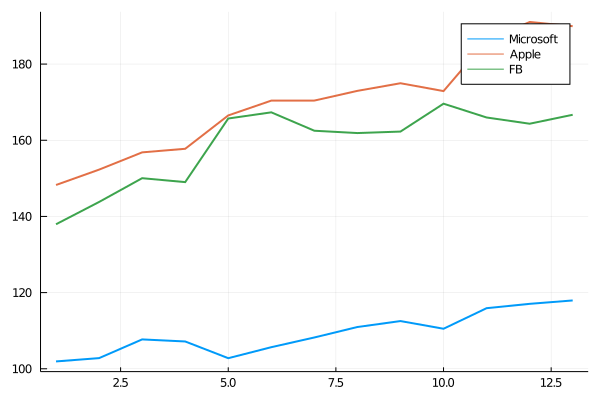

In [11]:
plot(stocks[!,:MSFT], label="Microsoft", linewidth=2)
plot!(stocks[!,:AAPL], label="Apple", linewidth=2)
plot!(stocks[!,:FB], label="FB", linewidth=2)

As usual, for mathematical procedures in Julia we will convert our key numerical data to a matrix

In [12]:
price_matrix = Matrix(stocks)

13×3 Array{Any,2}:
 101.93  137.95  148.26
 102.8   143.8   152.29
 107.71  150.04  156.82
 107.17  149.01  157.76
 102.78  165.71  166.52
   ⋮             
 112.53  162.28  174.97
 110.51  169.6   172.91
 115.91  165.98  186.12
 117.05  164.34  191.05
 117.94  166.69  189.95

Now stocks are not just about the actual price, but the return. Specifically we will be interested in the weekly return using the formula:

> R[i,t] = (price[i,t] - price[i,t-1])/price[i,t-1]

for stock i and week t.

We can implement this numerically by shifting the matrix by one week and using that to calculate the return per week and stock from the original matrix:

In [15]:
M_t1 = price_matrix[1:end-1,:]
M_t2 = price_matrix[2:end,:]

return_matrix = (M_t2.-M_t1)./M_t1

12×3 Array{Float64,2}:
  0.00853527   0.0424067    0.027182
  0.0477626    0.0433936    0.0297459
 -0.00501346  -0.00686484   0.00599413
 -0.040963     0.112073     0.0555274
  0.0281183    0.00977611   0.0233606
  ⋮                        
  0.0140579    0.00240904   0.0115627
 -0.0179508    0.0451072   -0.0117734
  0.0488644   -0.0213443    0.0763981
  0.00983522  -0.00988071   0.0264883
  0.00760359   0.0142996   -0.00575766

Next, we will model the risk matrix. We will skip the derivation of the risk matrix here, but you can read about it here: https://www.kdnuggets.com/2019/06/optimization-python-money-risk.html. The risk matrix will be the covariance matrix of the computed return prices (R).

In [16]:
risk_matrix = cov(return_matrix)

3×3 Array{Float64,2}:
  0.000659383  -0.000630653  0.000139112
 -0.000630653   0.00152162   0.000192288
  0.000139112   0.000192288  0.000635503

In [17]:
isposdef(risk_matrix)

true

### Modelling the allocation problem:

Now let's assume that the vector x = [x1 x2 x3] will contain the total number of dollars we will invest in these companies, i.e. x1 is how much we will invest in the first company (MSFT), x2 is how much we will invest in FB, and x3 is how much we will invest in AAPL. The return on the investment will be dot(r,x), where r = [r1 r2 r3] is the return from each of the companies.

Here, r is a random variable and we will have to model it in terms of expected return. And the expected return E(dot(r,x)) will be E[dot(mean(R,dims=2),x). If we want a return of 10% or more, then we need dot(r,x) >= 0.1.

In [18]:
r = mean(R,dims=1)[:]   # expected return

3-element Array{Float64,1}:
 0.012532748705136572
 0.016563036855293173
 0.02114580465503291

Now let's solve the following problem: Someone gives you $1000 and tells you to spend them in the form of investment on these three compnaies such that you get a return of 2\% on what you spent.

The goal will be to minimize the risk, that is x'*risk_matrix*x. The constraints will be
    
- sum(x) = 1, we will compute the percentage of investment rather than the exact amount
- dot(r,x) >= 0.02
- x[i] >= 0
    
This problem is a convext problem, and we will use `Convex.jl` to it.    

In [19]:
x = Convex.Variable(length(r))
problem = Convex.minimize(x'*risk_matrix*x, [sum(x) == 1; r'*x >= 0.02; x .>= 0])

minimize
└─ * (Convex.NotDcp; real)
   ├─ * (affine; real)
   │  ├─ adjoint (affine; real)
   │  │  └─ …
   │  └─ 3×3 Array{Float64,2}
   └─ 3-element real variable (id: 631…777)
subject to
├─ == constraint (affine)
│  ├─ sum (affine; real)
│  │  └─ 3-element real variable (id: 631…777)
│  └─ 1
├─ >= constraint (affine)
│  ├─ * (affine; real)
│  │  ├─ [0.0125327 0.016563 0.0211458]
│  │  └─ 3-element real variable (id: 631…777)
│  └─ 0.02
├─ >= constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 3-element real variable (id: 631…777)
│  └─ 0
├─ >= constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 3-element real variable (id: 631…777)
│  └─ 0
└─ >= constraint (affine)
   ├─ index (affine; real)
   │  └─ 3-element real variable (id: 631…777)
   └─ 0

status: `solve!` not called yet

┌ Warning: Expression not DCP compliant. Trying to solve non-DCP compliant problems can lead to unexpected behavior.
└ @ Convex /home/josinai/.julia/packages/Convex/Zv1ch/src/dcp.jl:25


Note the Convex.NotDcp in the answer above and the warning. Convex.jl requires that we pass DCP compliant problem (Disciplined convex programming). Learn more about the DCP ruleset here: http://cvxr.com/cvx/doc/dcp.html

In [20]:
# make the problem DCP compliant using a Convex DCP quadratic function instead of writing the expression in plain Julia
problem = Convex.minimize(Convex.quadform(x, risk_matrix), [sum(x) == 1; r'*x >= 0.02; x .>= 0])

minimize
└─ * (convex; positive)
   ├─ 1
   └─ qol_elem (convex; positive)
      ├─ norm2 (convex; positive)
      │  └─ …
      └─ [1.0]
subject to
├─ == constraint (affine)
│  ├─ sum (affine; real)
│  │  └─ 3-element real variable (id: 631…777)
│  └─ 1
├─ >= constraint (affine)
│  ├─ * (affine; real)
│  │  ├─ [0.0125327 0.016563 0.0211458]
│  │  └─ 3-element real variable (id: 631…777)
│  └─ 0.02
├─ >= constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 3-element real variable (id: 631…777)
│  └─ 0
├─ >= constraint (affine)
│  ├─ index (affine; real)
│  │  └─ 3-element real variable (id: 631…777)
│  └─ 0
└─ >= constraint (affine)
   ├─ index (affine; real)
   │  └─ 3-element real variable (id: 631…777)
   └─ 0

status: `solve!` not called yet

In [21]:
solve!(problem, SCS.Optimizer)

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 24, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 6, constraints m = 14
Cones:	primal zero / dual free vars: 2
	linear vars: 5
	soc vars: 7, soc blks: 2
Setup time: 4.99e-04s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.71e+19  2.86e+19  1.00e+00 -3.40e+19  5.17e+18  5.49e+19  3.45e-05 
   100| 1.81e-06  2.82e-04  3.06e-06  4.86e-04  4.83e-04  2.11e-16  6.36e-03 
   120| 2.41e-11  1.58e-10  5.37e-11  4.85e-04 

Let's get the optimal x

In [22]:
x

Variable
size: (3, 1)
sign: real
vexity: affine
id: 631…777
value: [0.06795412601815369, 0.12230861133050193, 0.8097372626814734]

Let's check the constraints

In [32]:
@show all(x.value .>= 0)
@show sum(x.value)
expected_return = r' * x.value 
@show expected_return[1] >= 0.02;
@show expected_return[1];

all(x.value .>= 0) = true
sum(x.value) = 1.000000000030129
expected_return[1] >= 0.02 = true
expected_return[1] = 0.02000000000061304


How much should we invest in each stock?

In [36]:
portfolio = Dict{String, Float64}()
for (x_i, stock) in zip(x.value, ["MSFT", "FB", "AAPL"])
    portfolio[stock] = x_i * 1000
end

portfolio

Dict{String,Float64} with 3 entries:
  "MSFT" => 67.9541
  "FB"   => 122.309
  "AAPL" => 809.737

## Problem 2: Image Reconstruction

In this problem we will purposely destroy information in an image and we will attempt to recover the damaged pixels by solving an optimization problem.

┌ Info: Precompiling ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
└ @ Base loading.jl:1278
┌ Info: Precompiling PNGFiles [f57f5aa1-a3ce-4bc8-8ab9-96f992907883]
└ @ Base loading.jl:1278


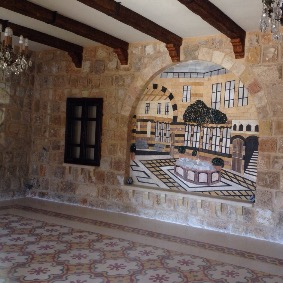

In [37]:
ref_image = load("data/khiam-small.jpg")

Convert to grayscale and remove pixel information

In [38]:
query_image = copy(ref_image)
P = prod(size(query_image))  # total number of pixels

80089

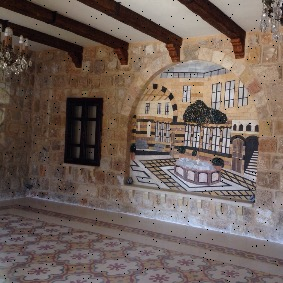

In [39]:
missing_pixels = rand(1:P, 400)
query_image[missing_pixels] .= RGBX{N0f8}(0.0, 0.0, 0.0)
query_image

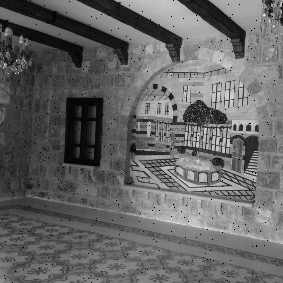

In [43]:
Gray.(query_image)

In [44]:
Y = Float64.(Gray.(query_image));

### Matrix Completion

Y is a matrix of grayscale pixel values. The goals is given this image, we need to complete the matrix. 

We will use a common technique for this problem developed by Candes and Tao. The goal will be to create a new matrix X where we minimize the nuclear norm of X (i.e. the sum of the singular values of X), and such that the entries that are already known in Y remain the same in X. We will again use Convex.jl to solve this problem. Let's write it down below.

In [46]:
correct_pixels = findall(Y[:] .!= 0)

X = Convex.Variable(size(Y))
problem = minimize(nuclearnorm(X), [ X[correct_pixels] == Y[correct_pixels] ])

minimize
└─ nuclearnorm (convex; positive)
   └─ 283×283 real variable (id: 114…842)
subject to
└─ == constraint (affine)
   ├─ index (affine; real)
   │  └─ 283×283 real variable (id: 114…842)
   └─ 79689-element Array{Float64,1}

status: `solve!` not called yet

In [47]:
solve!(problem, SCS.Optimizer(eps=1e-3, alpha=1.5))

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 400329, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 240268, constraints m = 400046
Cones:	primal zero / dual free vars: 239585
	sd vars: 160461, sd blks: 1
Setup time: 1.19e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.04e+21  5.63e+19  1.00e+00 -1.54e+24  1.44e+22  1.15e+24  6.29e-01 
   100| 3.44e-02  2.40e-02  2.86e-05  4.41e+02  4.41e+02  7.00e-15  2.80e+01 
   200| 1.29e-02  7.26e-03  6.98e-06  4.45

norm(float.(Gray.(ref_image)) - X.value) = 1.0831648393041509
norm(-(X.value)) = 124.32632945273062


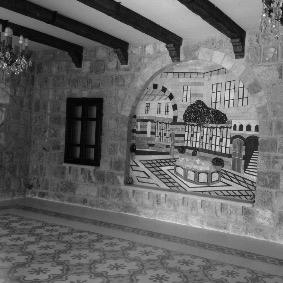

In [48]:
@show norm(float.(Gray.(ref_image)) - X.value)
@show norm(-X.value)
colorview(Gray, X.value)

We have a reconstructed image with very little data loss.

What if we lost 2400 pixels?


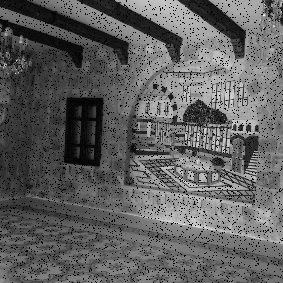

In [51]:
missing_pixels = rand(1:P, 2400)
query_image[missing_pixels] .= RGBX{N0f8}(0.0, 0.0, 0.0)
Y = Float64.(Gray.(query_image));

Gray.(query_image)

In [52]:
correct_pixels = findall(Y[:] .!= 0)

X = Convex.Variable(size(Y))
problem = minimize(nuclearnorm(X), [ X[correct_pixels] == Y[correct_pixels] ])

solve!(problem, SCS.Optimizer(eps=1e-3, alpha=1.5))

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 395325, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 240268, constraints m = 395042
Cones:	primal zero / dual free vars: 234581
	sd vars: 160461, sd blks: 1
Setup time: 1.25e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.04e+21  5.63e+19  1.00e+00 -1.50e+24  1.38e+22  1.12e+24  3.24e-01 
   100| 1.60e-01  8.96e-02  5.68e-04  4.33e+02  4.32e+02  2.74e-15  2.37e+01 
   200| 2.17e-02  9.79e-03  1.18e-04  4.37

norm(float.(Gray.(ref_image)) - X.value) = 4.530145286088951
norm(-(X.value)) = 124.16939064254414


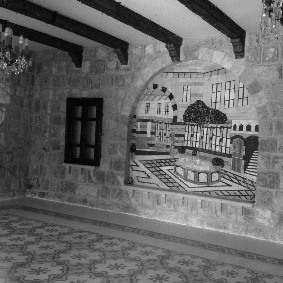

In [53]:
@show norm(float.(Gray.(ref_image)) - X.value)
@show norm(-X.value)
colorview(Gray, X.value)

Wow it worked

## Problem 3: Diet Optimization Problem

This is a common problem in Numerical Optimization, and you can find multiple references about it online. Here, we will use one of the examples in the JuMP package. Refer to this page for details: https://github.com/JuliaOpt/JuMP.jl/blob/master/examples/diet.jl.

In this prolem we are given constraints on the number of (minimum, maximum) number of calories, protein, fat, and sodium to consume. We will first build a JuMP container to store this information and pass it as constraints later.

In [58]:
categorical_space = JuMP.Containers.DenseAxisArray(
    [1800 2200;
     91   Inf;
     0    65;
     0    1779], 
    ["calories", "protein", "fat", "sodium"], 
    ["min", "max"])

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, ["calories", "protein", "fat", "sodium"]
    Dimension 2, ["min", "max"]
And data, a 4×2 Array{Float64,2}:
 1800.0  2200.0
   91.0    Inf
    0.0    65.0
    0.0  1779.0

You can think of the values as being a matrix which is indexed along rows by the vector `["calories", "protein", "fat", "sodium"]` and indexed along columns by the `["min", "max"]` vector. These indices span a "continuous" space which JuMP will operate in.

In [59]:
@show categorical_space["calories","max"] 
@show categorical_space["fat","min"];

categorical_space["calories", "max"] = 2200.0
categorical_space["fat", "min"] = 0.0


Now let's encode some information about the foods, using the same concept above

In [60]:
foods = ["hamburger", "chicken", "hot dog", "fries", "macaroni", "pizza","salad", "milk", "ice cream"]

cost = JuMP.Containers.DenseAxisArray(
    [2.49, 2.89, 1.50, 1.89, 2.09, 1.99, 2.49, 0.89, 1.59],
    foods)

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, ["hamburger", "chicken", "hot dog", "fries", "macaroni", "pizza", "salad", "milk", "ice cream"]
And data, a 9-element Array{Float64,1}:
 2.49
 2.89
 1.5
 1.89
 2.09
 1.99
 2.49
 0.89
 1.59

Next we will create a new matrix to encode the calories,protein, fat, and sodium present in each of these foods. This will be a matrix encoded by foods by rows, and ["calories", "protein", "fat", "sodium"] by columns.

In [62]:
food_calorie_space = JuMP.Containers.DenseAxisArray(
    [410 24 26 730;
     420 32 10 1190;
     560 20 32 1800;
     380  4 19 270;
     320 12 10 930;
     320 15 12 820;
     320 31 12 1230;
     100  8 2.5 125;
     330  8 10 180], 
    foods, 
    ["calories", "protein", "fat", "sodium"])

@show food_calorie_space["chicken", "fat"]
@show food_calorie_space["milk", "sodium"]
;

food_calorie_space["chicken", "fat"] = 10.0
food_calorie_space["milk", "sodium"] = 125.0


#### Now build the model

In [63]:
# set up the model
model = Model(GLPK.Optimizer)

categories = ["calories", "protein", "fat", "sodium"]

# add the variables
@variables(model, begin
    # Variables for nutrition info
    categorical_space[c, "min"] <= nutrition[c = categories] <= categorical_space[c, "max"]
    # Variables for which foods to buy
    buy[foods] >= 0
end)

# Objective - minimize cost
@objective(model, Min, sum(cost[f] * buy[f] for f in foods))

# Nutrition constraints
@constraint(model, [c in categories],
    sum(food_calorie_space[f, c] * buy[f] for f in foods) == nutrition[c]
)

1-dimensional DenseAxisArray{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.EqualTo{Float64}},ScalarShape},1,...} with index sets:
    Dimension 1, ["calories", "protein", "fat", "sodium"]
And data, a 4-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.EqualTo{Float64}},ScalarShape},1}:
 -nutrition[calories] + 410 buy[hamburger] + 420 buy[chicken] + 560 buy[hot dog] + 380 buy[fries] + 320 buy[macaroni] + 320 buy[pizza] + 320 buy[salad] + 100 buy[milk] + 330 buy[ice cream] = 0.0
 -nutrition[protein] + 24 buy[hamburger] + 32 buy[chicken] + 20 buy[hot dog] + 4 buy[fries] + 12 buy[macaroni] + 15 buy[pizza] + 31 buy[salad] + 8 buy[milk] + 8 buy[ice cream] = 0.0
 -nutrition[fat] + 26 buy[hamburger] + 10 buy[chicken] + 32 buy[hot dog] + 19 buy[fries] + 10 buy[macaroni] + 12 buy[pizza] + 12 buy[salad] + 2.5 buy[milk] + 10 buy[ice cream] = 0.0
 -

In [64]:
# solve
JuMP.optimize!(model)

term_status = JuMP.termination_status(model)
is_optimal = term_status == MOI.OPTIMAL

@show JuMP.primal_status(model) == MOI.FEASIBLE_POINT
@show JuMP.objective_value(model) ≈ 11.8288 atol = 1e-4

JuMP.primal_status(model) == MOI.FEASIBLE_POINT = true
JuMP.objective_value(model) ≈ 11.8288 = false
atol = 0.0001 = 0.0001


0.0001

And to actually look at the solution, we can look at the buy variable.

In [65]:
hcat(buy.data,JuMP.value.(buy.data))

9×2 Array{GenericAffExpr{Float64,VariableRef},2}:
 buy[hamburger]  0.6045138888888888
 buy[chicken]    0
 buy[hot dog]    0
 buy[fries]      0
 buy[macaroni]   0
 buy[pizza]      0
 buy[salad]      0
 buy[milk]       6.9701388888888935
 buy[ice cream]  2.591319444444441

## Problem 3: How many passports do you need to travel the world without obtaining a visa in advance?

This problem is the same problem shown in the JuliaCon 2018 JuMP workshop, with updated code and data. The original post can be found here: https://github.com/juan-pablo-vielma/JuliaCon2018_JuMP_Workshop/blob/master/Introduction_Slides.ipynb.

We will first get the data.

In [66]:
;git clone https://github.com/ilyankou/passport-index-dataset.git

Cloning into 'passport-index-dataset'...


> The file we need is passport-index-dataset/passport-index-matrix.csv, and we will use the DelimitedFiles package to read it -- this is mainly because what we are loading is a matrix and we will have to extract the matrix out of the DataFrame if we use the CSV package. Both are viable options, this will just be quicker.

To keep things consistent with Huda's notebook we will actually use the data in `legacy/2020-05-09/` which also excludes covid bans.

In [68]:
passport_data = readdlm(joinpath("passport-index-dataset", "legacy", "2020-05-09", "passport-index-matrix.csv"), ',')

200×200 Array{Any,2}:
 "Passport"       "Afghanistan"    "Albania"    "Algeria"    "Andorra"    "Angola"  …    "Vanuatu"    "Vatican"    "Venezuela"    "Vietnam"    "Yemen"    "Zambia"    "Zimbabwe"
 "Afghanistan"  -1                 "VR"         "VR"         "VR"         "VR"           "VR"         "VR"         "VR"           "VR"         "VR"       "VR"        "VR"
 "Albania"        "VR"           -1             "VR"       90             "VR"           "VR"       90             "VR"           "VR"         "VR"       "ETA"       "ETA"
 "Algeria"        "VR"             "VR"       -1             "VR"         "ETA"          "VR"         "VR"         "VR"           "VR"         "ETA"      "VR"        "ETA"
 "Andorra"        "VR"           90             "VR"       -1             "VR"         30           90           90               "ETA"        "VR"       "ETA"       "ETA"
 ⋮                                                                       ⋮          ⋱                             

These are the possible options in this matrix:

- **7-360:** 	number of visa-free days
- **VF:** 	visa-free travel (where number of days is not applicable or known, eg freedom of movement)
- **VOA:** 	visa on arrival
- **ETA:** 	eTA (electronic travel authority) required
- **VR:** 	visa required
- **-1:** 	where passport=destination, in matrix files only

So anything that is a number or "VF" or "VOA", can be entered without a visa in advance.

In [73]:
countries = passport_data[2:end,1]
visa_free_mat = (x ->  typeof(x)==Int64 || x == "VF" || x == "VOA" ? 1 : 0).(passport_data[2:end, 2:end])  # sparse matrix: 1 => visa-free; 0 => visa required
;

Setup the optimisation problem as

- min sum(passports)
- s.t. access all other countries and need at least one passport

In [75]:
model = Model(GLPK.Optimizer)

@variable(model, passports[1:length(countries)], Bin)
@constraint(model, [ j=1:length(countries) ], sum( visa_free_mat[i,j] * passports[i] for i in 1:length(countries)) >= 1)
@objective(model, Min, sum(passports))



passports[1] + passports[2] + passports[3] + passports[4] + passports[5] + passports[6] + passports[7] + passports[8] + passports[9] + passports[10] + passports[11] + passports[12] + passports[13] + passports[14] + passports[15] + passports[16] + passports[17] + passports[18] + passports[19] + passports[20] + passports[21] + passports[22] + passports[23] + passports[24] + passports[25] + passports[26] + passports[27] + passports[28] + passports[29] + passports[30] + passports[31] + passports[32] + passports[33] + passports[34] + passports[35] + passports[36] + passports[37] + passports[38] + passports[39] + passports[40] + passports[41] + passports[42] + passports[43] + passports[44] + passports[45] + passports[46] + passports[47] + passports[48] + passports[49] + passports[50] + passports[51] + passports[52] + passports[53] + passports[54] + passports[55] + passports[56] + passports[57] + passports[58] + passports[59] + passports[60] + passports[61] + passports[62] + passports[63] + p

Now solve the problem to get the minimum number of passports required:

In [76]:
JuMP.optimize!(model)

In [77]:
print(JuMP.objective_value(model), " passports: ", join(countries[ findall(JuMP.value.(passports) .== 1) ], ", "))

21.0 passports: Afghanistan, Angola, Austria, Comoros, Congo, Eritrea, Gambia, Georgia, Hong Kong, India, Iraq, Kenya, Madagascar, Maldives, North Korea, Papua New Guinea, Seychelles, Singapore, Somalia, Tunisia, United Arab Emirates

### What about during covid times?

In [78]:
passport_data = readdlm(joinpath("passport-index-dataset", "passport-index-matrix.csv"), ',')

countries = passport_data[2:end,1]
visa_free_mat = (x ->  typeof(x)==Int64 || x == "visa free" || x == "visa on arrival" ? 1 : 0).(passport_data[2:end, 2:end])  # sparse matrix: 1 => visa-free; 0 => visa required
;

In [80]:
model = Model(GLPK.Optimizer)

@variable(model, passports[1:length(countries)], Bin)
@constraint(model, [ j=1:length(countries) ], sum( visa_free_mat[i,j] * passports[i] for i in 1:length(countries)) >= 1)
@objective(model, Min, sum(passports))

JuMP.optimize!(model)

In [81]:
print(JuMP.objective_value(model), " passports: ", join(countries[ findall(JuMP.value.(passports) .== 1) ], ", "))

39.0 passports: Afghanistan, Azerbaijan, Barbados, Belarus, Belgium, Bhutan, Brunei, Cambodia, Cameroon, Canada, Fiji, Germany, Hong Kong, Hungary, Indonesia, Iraq, Israel, Japan, Jordan, Kuwait, Laos, Macao, Malaysia, Marshall Islands, Mauritius, Micronesia, Mongolia, New Zealand, North Korea, Norway, Papua New Guinea, Singapore, Solomon Islands, Taiwan, Timor-Leste, Turkmenistan, Uganda, Uruguay, Vietnam